# COGS 108 - EDA Checkpoint

# Names

- Bridget Egan 
- Dillan Merchant
- Jennifer Hang
- Sam Zakeri
- Connie Chang

# Research Question

**How are American news headline sentiments correlated to their publication source's political leanings?** To do this, we wanted three sources that reflected 'far-left', 'centrist', and 'far-right' political leanings. Using both AllSides and MediaBiasFactCheck, Breitbart was evaluated as the most right-leaning news source of our dataset, CNN was evaluated as the most left-leaning news source, and NPR was evaluated as the most politically-centrist news source [1, 2, 3, 4, 5, 6, 7]. *We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative), and the more centrist news source, NPR, will be more neutral in sentiment.*
- [1] https://www.allsides.com/news-source/cnn-media-bias
- [2] https://mediabiasfactcheck.com/cnn/
- [3] https://mediabiasfactcheck.com/npr/
- [4] https://www.allsides.com/news-source/npr-media-bias
- [5] https://www.allsides.com/news-source/breitbart
- [6] https://mediabiasfactcheck.com/breitbart/
- [7] https://www.adfontesmedia.com/static-mbc/

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import word_tokenize, sent_tokenize, tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/began/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Cleaning

### The data is fairly clean to begin with; there are few missing values and the format is consistent throughout. The issue we have is there is a lot of data that we do not need to use. So, to get our data into a useable format, we will only select the three publications we plan to use, <font color='red'>Breitbart</font>, <font color='blue'>CNN</font>, and  <font color='green'>NPR</font>, and keep the dates and headlines from only 2,500 of each. We decided to limit the sampling of each because the dataset had a higher number of Breitbart articles than any other publication, and we wanted there to be a standard number of headlines for each source. 

In [2]:
#this imports the relevant data sets from three separate files, and sanitizes the input.

news1 = pd.read_csv('csv_files/articles1.csv', engine = 'python', error_bad_lines=False)
news2 = pd.read_csv('csv_files/articles2.csv', engine = 'python', error_bad_lines=False)
news3 = pd.read_csv('csv_files/articles3.csv', engine = 'python', error_bad_lines=False)

Skipping line 17535: field larger than field limit (131072)
Skipping line 1429: field larger than field limit (131072)
Skipping line 1469: field larger than field limit (131072)
Skipping line 1516: field larger than field limit (131072)
Skipping line 1740: field larger than field limit (131072)
Skipping line 3774: field larger than field limit (131072)
Skipping line 3779: field larger than field limit (131072)
Skipping line 3791: field larger than field limit (131072)
Skipping line 33121: field larger than field limit (131072)
Skipping line 34127: field larger than field limit (131072)


In [3]:
# combine three dataframes into one
news = news1.append(news2).append(news3)
news.shape

(142560, 10)

In [4]:
# check number of articles for each source
news['publication'].value_counts()

Breitbart              23780
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11112
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7172
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [5]:
#But we only care about the article title, where it comes from, and when it was published(for context of the news)

news_cleaned = news[['title', 'publication', 'date']]
news_cleaned.head()

,title,publication,date
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02


In [6]:
#Getting rid of all the null columns
news_cleaned = news_cleaned.dropna()
news_cleaned.isnull().values.any()

False

In [7]:
# keep news only from 'Breitbart', 'CNN', and 'NPR'
sources = ['Breitbart', 'CNN', 'NPR']
news = news_cleaned[news_cleaned['publication'].isin(sources)]

news['publication'].value_counts()

Breitbart    23780
NPR          11992
CNN          11488
Name: publication, dtype: int64

### After testing a fair amount, we found that the mean values stabilized at around 2500 samples for each of the sources. 


In [8]:
# pick 2500 random news for each source
news = news.groupby("publication").sample(n=2500)

news['publication'].value_counts()

NPR          2500
Breitbart    2500
CNN          2500
Name: publication, dtype: int64

In [9]:
news.head()

,title,publication,date
31415,Hillary: There’s ’Double Standard’ In Asking M...,Breitbart,2016-02-08
29349,The Church of Arlington National Cemetery - Br...,Breitbart,2016-05-29
10094,’Jobs!’ Donald Trump Celebrates Massive Stock ...,Breitbart,2017-03-02
10332,Stephen King Mocks Trump Wiretapping Claims wi...,Breitbart,2017-03-05
17340,NY Assemblywoman Claudia Tenney: Hillary Clint...,Breitbart,2016-10-23


# Data Analysis & Results (EDA)

### Let us first start with a general exploration of the average sentiments of each news source. Bearing in mind we are randomly choosing 2,500 articles from the original dataset each time this notebook is run, and therefore the averages will vary slightly. 
### The first part of the EDA is to make sure we have our sentiment analysis completed. We formatted the data, tokenized, stemmed, and used the nltk sentiment analyzer. 

In [10]:
news['title'] = news['title'].astype(str)
## Lowercase
news['title'] = news['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punct
def remove_punct(string):
    punctuation= '''‘’!()-[]{};:'", <>./?@#$%^&*_~'''
    for x in punctuation:
        string = string.replace(x, " ")
    return string

news['title'] = news['title'].apply(remove_punct)

#tokenize 
news['title'] = news['title'].apply(word_tokenize)

## stop word removal
stop_words = set(stopwords.words('english'))

#We see in the data that Breitbart and CNN frequently include the name of their publication at the end of each of their article titles, as such,
#we decided to add 'breitbart' and 'cnn' as a stop word so that it would be removed from the titles, and not dilute the sentiment of the rest
#of the article titles.
stop_words.add('breitbart')
stop_words.add('cnn')
news['title'] = news['title'].apply(lambda x: [item for item in x if item not in stop_words])

##stemming
stemmer = PorterStemmer()
news['title'] = news['title'].apply(lambda x: [stemmer.stem(y) for y in x])

news['tokenized_list'] = news['title']

# putting the tokenized, stemmed, and cleaned titles back into lists
def joiner(title_list): 
    return ' '.join(title_list)
news['title'] = news['title'].apply(joiner)

#Analysing the sentiment of each title and creating a new Dataframe of the compound of the sentiments
analyser = SentimentIntensityAnalyzer()
title_sentences = list(news['title'])
def senti(input_list):
    output = pd.DataFrame()
    for sentence in title_sentences:
        ss = analyser.polarity_scores(sentence)
        ss['cleaned_titles'] = sentence
        output = output.append(ss, ignore_index=True)
    return output

In [11]:
news_sentiments = senti(title_sentences)

In [12]:
#creating a combined dataframe of the titles, their publications, and the compound sentiment of their titles. 
news_sentiments
title_sentiments = pd.DataFrame(news_sentiments['compound']) 

title_sentiments
news = news.reset_index()
news['title_sentiment']  = news_sentiments['compound']
news

,index,title,publication,date,tokenized_list,title_sentiment
0,31415,hillari doubl standard ask releas speech said ...,Breitbart,2016-02-08,"[hillari, doubl, standard, ask, releas, speech...",0.0000
1,29349,church arlington nation cemeteri,Breitbart,2016-05-29,"[church, arlington, nation, cemeteri]",0.0000
2,10094,job donald trump celebr massiv stock market gain,Breitbart,2017-03-02,"[job, donald, trump, celebr, massiv, stock, ma...",0.5267
3,10332,stephen king mock trump wiretap claim short stori,Breitbart,2017-03-05,"[stephen, king, mock, trump, wiretap, claim, s...",-0.4215
4,17340,ny assemblywoman claudia tenney hillari clinto...,Breitbart,2016-10-23,"[ny, assemblywoman, claudia, tenney, hillari, ...",-0.5423
...,...,...,...,...,...,...
7495,11426,walgreen cut tie blood test compani therano,NPR,2016-06-13,"[walgreen, cut, tie, blood, test, compani, the...",-0.2732
7496,4046,donald trump cabinet stack 3 chart,NPR,2016-12-28,"[donald, trump, cabinet, stack, 3, chart]",0.0000
7497,12387,fail 6 michigan employe charg flint water crisi,NPR,2016-07-29,"[fail, 6, michigan, employe, charg, flint, wat...",-0.5423
7498,12080,ryan say believ trump go endeavor tri chang,NPR,2016-07-15,"[ryan, say, believ, trump, go, endeavor, tri, ...",0.0000


### To get a general feel, let's look at the numeric interpretations of the data. Specifically, the averages for the total dataset, then for each pulication's dataset. 

In [13]:
print("Sentiment Averages for all publications:")
news['title_sentiment'].describe()

Sentiment Averages for all publications:


count    7500.000000
mean       -0.095991
std         0.356948
min        -0.938200
25%        -0.340000
50%         0.000000
75%         0.000000
max         0.895700
Name: title_sentiment, dtype: float64

In [14]:
print('BREITBART, CNN, NPR sentiment averages, respectively:')
news[news['publication'] == 'Breitbart']['title_sentiment'].describe(), news[news['publication'] == 'CNN']['title_sentiment'].describe(), news[news['publication'] == 'NPR']['title_sentiment'].describe()

BREITBART, CNN, NPR sentiment averages, respectively:


(count    2500.000000
 mean       -0.136110
 std         0.366964
 min        -0.938200
 25%        -0.421500
 50%         0.000000
 75%         0.000000
 max         0.836000
 Name: title_sentiment, dtype: float64,
 count    2500.000000
 mean       -0.109179
 std         0.348724
 min        -0.931300
 25%        -0.340000
 50%         0.000000
 75%         0.000000
 max         0.851900
 Name: title_sentiment, dtype: float64,
 count    2500.000000
 mean       -0.042683
 std         0.348481
 min        -0.918600
 25%        -0.250000
 50%         0.000000
 75%         0.000000
 max         0.895700
 Name: title_sentiment, dtype: float64)

### The average total mean of the sentiment distribution is negative, which is to be expected, news is often negative, and negative stories are often overreported. But regarless of which samples we get each time we rerun this notebook, of the news sources, <font color='blue'>CNN</font> and <font color='red'>Breitbart</font> are always more negative, while <font color='green'>NPR</font> is the most neutral. This could be because <font color='blue'>CNN</font> and <font color='green'>NPR</font> choose to write about more negative topics, or that they generally write more negatively.

### The data could benefit from visual representation, so that we can see how often each source is more negative or positive. To show this, we made a histograms of combined sentiment of all the news sources, then from each specific publication. 

In [15]:
#creating a histogram plot of sentiment distribution based on the composite sentiment 
cnn = news[news['publication'] == 'CNN']
breitbart = news[news['publication'] == 'Breitbart']
npr = news[news['publication'] == 'NPR']

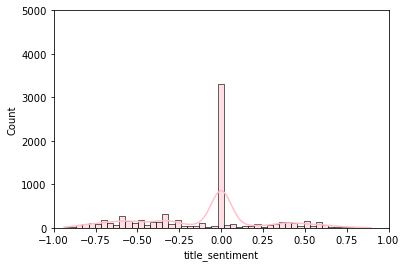

In [16]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');
total_plot.set(ylim=(0,5000));
total_plot.set(xlim=(-1,1));

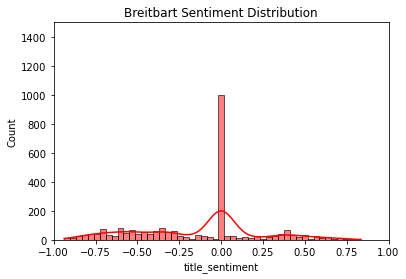

In [17]:
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')
breitbart_plot.set_title("Breitbart Sentiment Distribution")
breitbart_plot.set(ylim=(0,1500))
breitbart_plot.set(xlim=(-1,1));

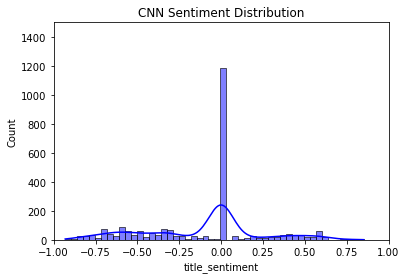

In [18]:
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');
cnn_plot.set_title("CNN Sentiment Distribution");
cnn_plot.set(ylim=(0,1500));
cnn_plot.set(xlim=(-1,1));

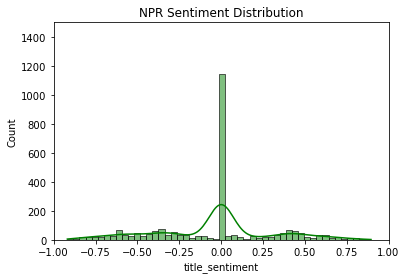

In [19]:
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');
npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(ylim=(0,1500));
npr_plot.set(xlim=(-1,1));

### For all of these graphs, we can see an obvious similarity: the large column of zero sentiments in the middle. This means a lot of headlines are being evaluated as having complete neutral sentiment. Is this is indicative of the writers of these publications clearly trying to craft the most neutral titles as possible? Or is it that many headlines have complete neutral sentiment due to shortness of title, errors in the stemmer, and/or frequent uses of names?


### We want to observe what is being said in these large, neutral columns, and if they're worth analysing at all. So let's see the top ten words for each column. 

In [20]:
sentiment_free = news[news.title_sentiment == 0.0]

breitbart_0sent = sentiment_free[sentiment_free['publication'] == 'Breitbart']
cnn_0sent = sentiment_free[sentiment_free['publication'] == 'CNN']
npr_0sent = sentiment_free[sentiment_free['publication'] == 'NPR']

total_worddist = sentiment_free['tokenized_list'].apply(pd.Series).stack()
total_fdist_most = FreqDist(total_worddist)

breitbart_worddist = breitbart_0sent['tokenized_list'].apply(pd.Series).stack()
bb_fdist_most = FreqDist(breitbart_worddist)

CNN_worddist = cnn_0sent['tokenized_list'].apply(pd.Series).stack()
cnn_fdist_most = FreqDist(CNN_worddist)
NPR_worddist = npr_0sent['tokenized_list'].apply(pd.Series).stack()
npr_fdist_most = FreqDist(NPR_worddist)

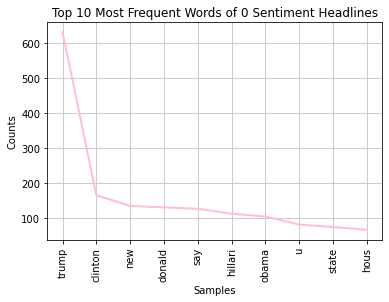

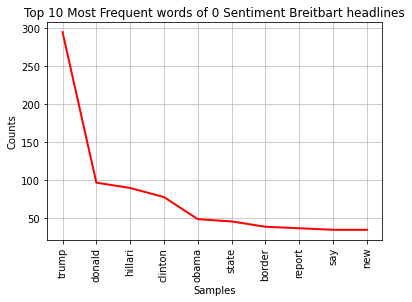

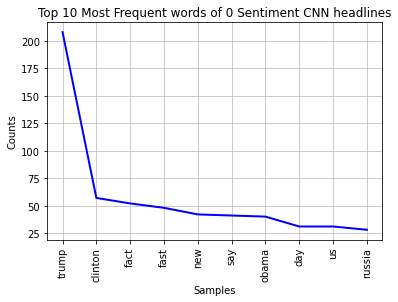

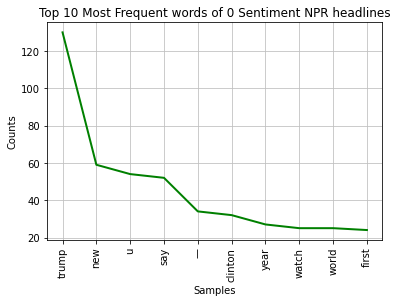

In [21]:
total_fdist_most.plot(10, cumulative=False, color = 'pink', title = 'Top 10 Most Frequent Words of 0 Sentiment Headlines');
bb_fdist_most.plot(10, cumulative=False, color = 'red', title = 'Top 10 Most Frequent words of 0 Sentiment Breitbart headlines');
cnn_fdist_most.plot(10, cumulative=False, color = 'blue', title = 'Top 10 Most Frequent words of 0 Sentiment CNN headlines');
npr_fdist_most.plot(10, cumulative=False, color = 'green', title = 'Top 10 Most Frequent words of 0 Sentiment NPR headlines');

### Well, it seems like the words of the neutral titles *are* largely a reflection of names, who the articles are talking about. Since names are always given 0 weight, it follows that the most frequent word across the US news sources is that of the US president during the data's time of data collection, 2015-2019. The words seem to be similar across news publications, but notably, <font color='green'>NPR</font> seems to name-drop the least, with only two of its most frequent words being names of politicians, and <font color='red'>Breitbart</font> seems to have the most, with six of the top ten being names of US political figures; <font color='blue'>CNN</font> sits at three. 

### This could indicate that <font color='red'>Breitbart</font> talks about the US political sphere more than <font color='blue'>CNN</font> or <font color='green'>NPR</font>, and that <font color='blue'>CNN</font> and <font color='green'>NPR</font> talk more about general US news. But let's see how these publications talk about their chosen news material. 


### To view the data with a more critical lens, we decided to remove all of the zero sentiments across the board. It is important to note that both <font color='green'>NPR</font> and <font color='blue'>CNN</font> have nearly three hundred more sentiment neutral titles than <font color='red'>Breitbart</font>, but we feel that the data can be analyzed adequately without the large column in the middle. By removing the neutral titles, we will be able to see the general skew of articles that have more polar sentiments, and hopefully answer our question of whether the more poltically polar sources have more polar sentiment.

In [22]:
#get rid of 0 values (outlier)
news = news[news.title_sentiment != 0]
news.head()
##Pay attention to the words that are not stemmed properly!!

,index,title,publication,date,tokenized_list,title_sentiment
2,10094,job donald trump celebr massiv stock market gain,Breitbart,2017-03-02,"[job, donald, trump, celebr, massiv, stock, ma...",0.5267
3,10332,stephen king mock trump wiretap claim short stori,Breitbart,2017-03-05,"[stephen, king, mock, trump, wiretap, claim, s...",-0.4215
4,17340,ny assemblywoman claudia tenney hillari clinto...,Breitbart,2016-10-23,"[ny, assemblywoman, claudia, tenney, hillari, ...",-0.5423
5,21928,milo gun free zone safe space killer,Breitbart,2016-06-16,"[milo, gun, free, zone, safe, space, killer]",-0.1280
6,12277,nigerian archbishop call govt protect christia...,Breitbart,2017-04-03,"[nigerian, archbishop, call, govt, protect, ch...",-0.2023


### This will probably move the average sentiment to the left, but let's check anyway.

In [23]:
news['title_sentiment'].describe()

count    4183.000000
mean       -0.172109
std         0.464076
min        -0.938200
25%        -0.557400
50%        -0.318200
75%         0.296000
max         0.895700
Name: title_sentiment, dtype: float64

In [24]:
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

print('BREITBART, CNN, NPR sentiment averages, respectively:')
breitbart['title_sentiment'].describe(), cnn['title_sentiment'].describe(), npr['title_sentiment'].describe()

BREITBART, CNN, NPR sentiment averages, respectively:


(count    1502.000000
 mean       -0.226548
 std         0.451328
 min        -0.938200
 25%        -0.585900
 50%        -0.340000
 75%         0.177900
 max         0.836000
 Name: title_sentiment, dtype: float64,
 count    1326.000000
 mean       -0.205844
 std         0.457652
 min        -0.931300
 25%        -0.585900
 50%        -0.340000
 75%         0.226300
 max         0.851900
 Name: title_sentiment, dtype: float64,
 count    1355.000000
 mean       -0.078751
 std         0.470415
 min        -0.918600
 25%        -0.476700
 50%        -0.226300
 75%         0.401900
 max         0.895700
 Name: title_sentiment, dtype: float64)

### By removing the 0 column, we about doubled the average mean sentiment across the board. 

### Seeing how this was a uniform transformtion of the data, we feel comfortable analyzing the data without the 0 values moving forward. Let's take a look at the distributions now: 

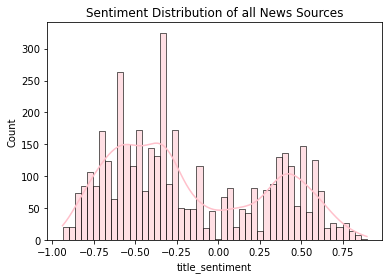

In [25]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');

total_plot.set_title("Sentiment Distribution of all News Sources");

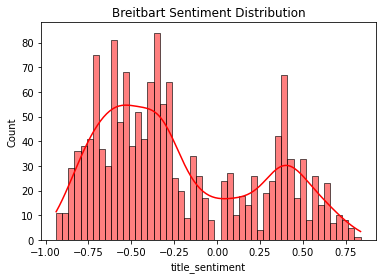

In [26]:
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')

breitbart_plot.set_title("Breitbart Sentiment Distribution");

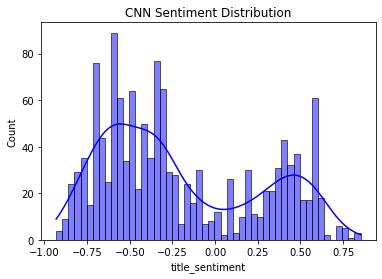

In [27]:
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');
cnn_plot.set_title("CNN Sentiment Distribution");

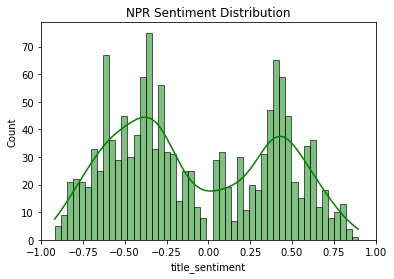

In [28]:
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');

npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(xlim=(-1,1));

### By removing the column in the middle, we can see a clearer pattern emerge. All of the news sources have an obvious bimodal distribution. But <font color='red'>Breitbart</font>and <font color='blue'>CNN</font> seem to have a skew to the right. 
### So we now combine the graphs to compare the general sentiment distribution of each source.

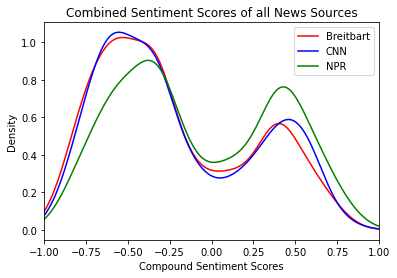

In [30]:
#To combine all the sentiment scores without the 0 sentiment data. 
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

Breitbart = list(breitbart['title'].values)
CNN = list(cnn['title'].values)
NPR = list(npr['title'].values)


#function that will output the dataframe that stores sentiment information
def get_sentiments(input_list):
    output = pd.DataFrame()
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)
    return output

breitbart_sentiments = get_sentiments(Breitbart)
breitbart_sentiments['compound'].plot.density(color = 'red', label = 'Breitbart')

cnn_sentiments = get_sentiments(CNN)
cnn_sentiments['compound'].plot.density(color = 'blue', label = 'CNN')

npr_sentiments = get_sentiments(NPR)
npr_sentiments['compound'].plot.density(color = 'green', label = 'NPR')


plt.legend(loc = 'upper right')
plt.xlabel('Compound Sentiment Scores')
plt.xlim(-1,1);
plt.title("Combined Sentiment Scores of all News Sources");

### By showing all the news sentiment scores on one graph, we can clearly see that <font color='blue'>CNN</font> and <font color='red'>Breitbart</font> have a distinct rightward skew, meaning that the average sentiment of their article titles is more negative than positive. This is in contrast to <font color='green'>NPR</font>, which shows a more balanced bimodal distribution with no clear skew to the left or to the right. <font color='blue'>CNN</font> also seems to be slightly more negative than <font color='red'>Breitbart</font>. 


### But we should still ask the question, which words show up the most for all the publications, for each individual publication? Will these words be more negative, positive, or neutral? To do this, we will take the stemmed and stop word removed titles and look at them for the top word frequencies.

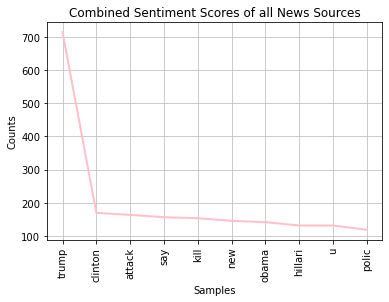

In [31]:
combined_news_publications = news['tokenized_list'].apply(pd.Series).stack()
# calculation word frequency
fdist_most = FreqDist(combined_news_publications)

# Frequency Distribution Plot - top 10 most common words
fdist_most.plot(10, cumulative=False, color = 'pink', title = 'Combined Sentiment Scores of all News Sources');

In [32]:
totalNPR = news['tokenized_list'][(news['publication'] == 'NPR')].apply(pd.Series).stack()
totalCNN = news['tokenized_list'][(news['publication'] == 'CNN')].apply(pd.Series).stack()
totalBreitbart = news['tokenized_list'][(news['publication'] == 'Breitbart')].apply(pd.Series).stack()

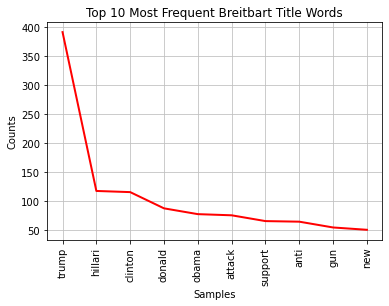

In [33]:
fdist_most = FreqDist(totalBreitbart) 
fdist_most.plot(10, cumulative=False, color = 'red', title = 'Top 10 Most Frequent Breitbart Title Words');

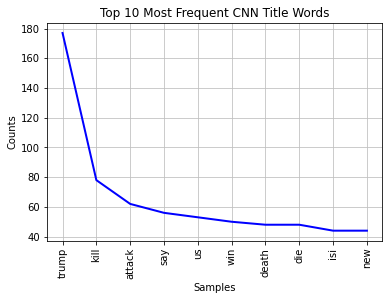

In [34]:
fdist_most = FreqDist(totalCNN) 
fdist_most.plot(10, cumulative=False, color = 'blue', title = 'Top 10 Most Frequent CNN Title Words');

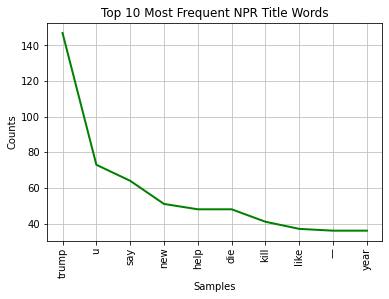

In [35]:
fdist_most = FreqDist(totalNPR) 
fdist_most.plot(10, cumulative=False, color = 'green', title = 'Top 10 Most Frequent NPR Title Words');

### The sentiment-focused plot of most frequent words still reflects the zero sentiment's conclusion that names are most frequently used in <font color='red'>Breitbart</font> titles. 

### We can see from these most frequent words that the name "Trump" is the most common word used across the publications, which can be ascribed to the time in which the data was collected, starting from the election of 2016 and through his presidency. The rest of the distributions seem to show a propensity for intensely negative words, such as 'kill', 'die', 'attack', and 'death', which could be due to news outlets over-reporting violent events. "Though, it should be noted that <font color='green'>NPR</font> seems to have these words further down the list, and <font color='blue'>CNN</font> has the highest frequency of these 'violent' words. 


### But how about we look at all the news titles that include the word 'Trump' and see the sentiments for each news source as they relate to the former president. For each source to talk about the same topic, we might be able to find a better method of comparison. For example, <font color='red'>Breitbart</font>, being more politcally in line with the former president, might have a more positive sentiment than the other two news sources. Let's test it by splitting the dataset into stories about Trump, and not about Trump. 

In [36]:
#About 700/2500 titles include Trump's name 
total_trump = news[news['title'].str.contains('trump')]
not_trump = news[~news['title'].str.contains('trump')]

not_trump.shape, total_trump.shape

((3475, 6), (708, 6))

In [37]:
breit_trump = breitbart[breitbart['title'].str.contains('trump')]
npr_trump = npr[npr['title'].str.contains('trump')]
cnn_trump = cnn[cnn['title'].str.contains('trump')]

not_breit_trump = breitbart[~breitbart['title'].str.contains('trump')]
not_npr_trump = npr[~npr['title'].str.contains('trump')]
not_cnn_trump = cnn[~cnn['title'].str.contains('trump')]

In [45]:
print('Average sentiment of: \n')
print(' ALL articles:                  ', news['title_sentiment'].mean())
print(' Articles REGARDING TRUMP:      ', total_trump['title_sentiment'].mean())
print(' Articles NOT regarding Trump:  ', not_trump['title_sentiment'].mean())

Average sentiment of: 

 ALL articles:                   -0.1721088692326083
 Articles REGARDING TRUMP:       -0.12189209039548049
 Articles NOT regarding Trump:   -0.18234008633093549


### Interestingly, articles regarding Trump are more positive on average, let's see if this is reflected cross-publication, by looking at the averages of ALL articles, articles regarding Trump, and articles that don't mention Trump. 

In [46]:
print('Average sentiment of: \n')
print(' ALL Breitbart articles:                ', breitbart['title_sentiment'].mean())
print(' Breitbart articles regarding Trump:    ', breit_trump['title_sentiment'].mean())
print(' Breitbart articles NOT regarding Trump:', not_breit_trump['title_sentiment'].mean(), '\n')

print(' ALL CNN articles:                      ', cnn['title_sentiment'].mean())
print(' CNN articles regarding Trump:          ', cnn_trump['title_sentiment'].mean())
print(' CNN NOT regarding Trump:               ', not_cnn_trump['title_sentiment'].mean(), '\n')

print(' ALL NPR articles:                      ', npr['title_sentiment'].mean())
print(' NPR articles regarding Trump:          ', npr_trump['title_sentiment'].mean())
print(' NPR articles NOT regarding Trump:      ', not_npr_trump['title_sentiment'].mean())

Average sentiment of: 

 ALL Breitbart articles:                 -0.2265480026631154
 Breitbart articles regarding Trump:     -0.13249636363636372
 Breitbart articles NOT regarding Trump: -0.25896508504923865 

 ALL CNN articles:                       -0.20584351432880846
 CNN articles regarding Trump:           -0.13345423728813552
 CNN NOT regarding Trump:                -0.2169948651000871 

 ALL NPR articles:                       -0.07875114391143934
 NPR articles regarding Trump:           -0.07991164383561643
 NPR articles NOT regarding Trump:       -0.07861100082713013


### <font color='green'>NPR</font> has nearly no difference in reporting about Trump vs. reporting about other things. However, it seems like both of the political news sources seem to have titles with more positive language when regarding Trump. Let's visualize the distributions of these articles. 

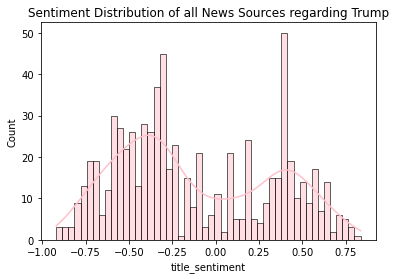

In [40]:
total_trump_plot = sns.histplot(total_trump['title_sentiment'], bins=50, kde=True, color = 'pink');
total_trump_plot.set_title("Sentiment Distribution of all News Sources regarding Trump");

    Combined Sentiment Distribution Regarding Trump


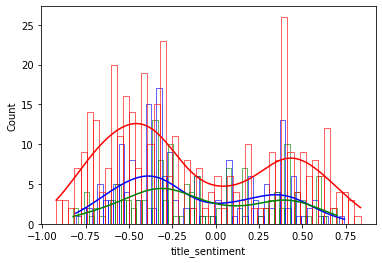

In [41]:
print('    Combined Sentiment Distribution Regarding Trump')
cnn_trump_plot = sns.histplot(cnn_trump['title_sentiment'], bins=50, kde=True, color = 'blue', fill=False);
npr_trump_plot = sns.histplot(npr_trump['title_sentiment'], bins=50, kde=True, color = 'green', fill=False);
breit_trump_plot = sns.histplot(breit_trump['title_sentiment'], bins=50, kde=True, color = 'red', fill=False);


### Obviously, these sources will feel differently about different topics, as we specifically selected them to be on different parts of the political spectrum. However, this plot shows us that when it comes to the most frequently talked about figure cross-publication, their sentiments match their overall sentiments about exactly. However, this plot does confirm an earlier suspicion, that <font color='red'>Breitbart</font> simply talks about Trump, and other political firgues, more. And as is reflected by earlier analysis, <font color='green'>NPR</font> mentioned Trump the least. 


# Conclusions 

### As for our original hypothesis: 
#### "*We hypothesize that the two more politically polar news sources, <font color='red'>Breitbart</font> and <font color='blue'>CNN</font>, will have more polar sentiment (as in frequently positive or negative), and the more centrist news source, <font color='green'>NPR</font>, will be more neutral in sentiment.* 

### We feel that our data does support our hypothesis. We origianlly predicted that <font color='blue'>CNN</font> and <font color='red'>Breitbart</font> would be more polar, positive or negative on average, due to the likely more policially polar nature of their material, and that <font color='green'>NPR</font> would be thoroughly neutral, as it is in its political leanings. <font color='green'>NPR</font> did end up being visibly more neutral than the other two, which were both strongly skewed to the right. We simply wanted to find an effect of polical leaning on general sentiment, and found that the two more politcal sources were more negative on average. From this, we can reject our null hypothesis, that all the publications would be the same in their sentiments, and conclude that, in the case of <font color='red'>Breitbart</font>, <font color='blue'>CNN</font>, and  <font color='green'>NPR</font>, the more polar the news source, the more polar the sentiment of the news headlines. 

## Limitations
### If we were to want to make a more general conclusion about whether political leaning of a news source directly affected or even predicted the general sentiment of its headlines, we would want to do a more in-depth analysis with more politically diverse sources, such as a center-left, center-right, center-center-right, etc. across a longer period of time. Yet there is not a direct measure for the *exact* politcal leaning of a source. As such, it would be difficult to draw a positive or negative correlation without a more objective, numeric measurement. 

# Privacy/Ethics Considerations:



_______________________________________________